<a href="https://colab.research.google.com/github/tirta-ir/Fun-Martingale-Counting-Cards/blob/main/Martingale-Counting-Cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blackjack Counting Cards Simulation
**Miftahul Tirta Ir** - I created a blackjack card counting simulation to show whether this method can statistically help you win at blackjack. As we know, gambling is a game of numbers, more precisely statistics and probability. I’m not encouraging you to gamble, but rather providing an overview of how state-of-the-art methods can statistically win this game. It should be noted that this code does not represent real casino gambling where the limitation on this code is that the player plays alone against the dealer and there are no other players at the table influencing the player’s decisions. This code and analysis is just a study conducted by me to refresh my Python and statistical knowledge.

In [30]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools

After importing the necessary Python modules, I created a deck and card class to define the stack of cards used. Many blackjack tables don’t use just one deck in their stack of cards, so I defined three decks for the stack.

In [31]:
class Card:
    def __init__(self, suit, value):
        self.suit = suit
        self.value = value

class Deck:
    def __init__(self, num_stacks=3):
        self.cards = self.generate_deck(num_stacks)

    def generate_deck(self, num_stacks):
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        values = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        return [Card(suit, value) for _ in range(num_stacks) for suit in suits for value in values]

    def shuffle(self):
        random.shuffle(self.cards)

    def deal(self):
        return self.cards.pop()

Next, I defined the player’s playstyle using card counting. As you may know, card counting is a strategy for playing blackjack that doesn’t necessarily involve remembering the cards played, but rather focuses on the points of your hand and the dealer’s hand. In this context, the player’s bank is 1 million rupiah with an initial bet of 50k rupiah for each hand.

Now, let’s delve a bit deeper into card counting. Card counting is a strategy that involves tracking the ratio of high to low cards left in the deck. The idea is that a deck rich in high cards (tens and aces) is favorable to the player, while a deck rich in low cards is favorable to the dealer. When the count is favorable, the player increases their bets to capitalize on the situation.

Conversely, when the count is unfavorable, the player decreases their bet or refrains from betting altogether. This strategy, while not foolproof, can significantly increase a player’s odds over the house in the long run.

I’m using the Martingale method to ensure that my next hand will cover my last hand’s losses by multiplying the previous bet into the next hand. Using this method, I’ll also ensure that the player mitigates the dealer’s blackjack by taking insurance if the player’s cards are feasible.

In [32]:
class Player:
    def __init__(self, balance=1000000, bet=50000):
        self.balance = balance
        self.bet = bet
        self.hand = []
        self.count = 0

    def draw(self, deck):
        card = deck.deal()
        self.hand.append(card)
        if card.value in ['2', '3', '4', '5', '6']:
            self.count += 1
        elif card.value in ['10', 'J', 'Q', 'K', 'A']:
            self.count -= 1
        return card

    def calculate_hand(self):
        ace_count = sum(card.value == 'A' for card in self.hand)
        total = sum(int(card.value) if card.value.isnumeric() else 10 for card in self.hand)
        while total > 21 and ace_count:
            total -= 10
            ace_count -= 1
        return total

    def adjust_bet(self, result):
        if result == 'win':
            self.bet = 50000
        elif result == 'lose' and self.count > 0:
            self.bet *= 2
    def take_insurance(self):
      return self.count > 0

class Dealer(Player):
    def play_turn(self, deck):
        while self.calculate_hand() < 17:
            self.draw(deck)

After that, at the start of the first play, the deck will be shuffled once to ensure that each first hand is randomized. Then, if the deck has fewer than 40 cards, it will be reshuffled. All of the outputs for the play will be recorded in a graph and table to analyze the results of this playstyle.

In [33]:
class Game:
    def __init__(self):
        self.deck = Deck()
        self.player = Player()
        self.dealer = Dealer()
        self.results = []
        self.hand_results = []
        self.decisions = pd.DataFrame(columns=['Hand', 'Dealer_Cards', 'Player_Cards', 'Decision'])
        self.insurances_taken = 0

    def play_round(self, i):
        if i == 0 or len(self.deck.cards) <= 40:
            print("Reshuffling the deck.")
            self.deck = Deck()
            self.deck.shuffle()
        self.player.hand = []
        self.dealer.hand = []

        for _ in range(2):
            self.player.draw(self.deck)
            self.dealer.draw(self.deck)

        if self.dealer.hand[0].value == 'A' and self.player.take_insurance():
           print("Player takes insurance.")
           self.insurances_taken += 1
        self.dealer.play_turn(self.deck)

        if self.player.calculate_hand() < 17:
          decision = 'Hit'
          self.player.draw(self.deck)
        else:
          decision = 'Stand'

        player_total = self.player.calculate_hand()
        dealer_total = self.dealer.calculate_hand()

        if player_total > 21 or (dealer_total <= 21 and dealer_total > player_total):
          result = 'lose'
        elif dealer_total == player_total:
          result = 'draw'
        else:
          result = 'win'
        self.results.append(self.player.balance)

        if result == 'win':
          amount = self.player.bet
        elif result == 'lose':
          amount = -self.player.bet
        else:
          amount = 0

        self.decisions = self.decisions.append({'Hand': i+1, 'Dealer_Cards': [card.value for card in self.dealer.hand],
                                                'Player_Cards': [card.value for card in self.player.hand],
                                                'Bet': self.player.bet, 'Result': result,
                                                'Amount': amount, 'Decision': decision}, ignore_index=True)
        self.update_balance(result)

    def update_balance(self, result):
        if result == 'win':
            self.player.balance += self.player.bet
        elif result == 'lose':
            self.player.balance -= self.player.bet
        self.player.adjust_bet(result)

    def plot_balance(self):
        plt.plot(self.results)
        plt.xlabel('Hand')
        plt.ylabel('Balance')
        plt.show()

Reshuffling the deck.
Reshuffling the deck.
Reshuffling the deck.
Reshuffling the deck.


<ipython-input-33-22c88ec2406d>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.decisions = self.decisions.append({'Hand': i+1, 'Dealer_Cards': [card.value for card in self.dealer.hand],
<ipython-input-33-22c88ec2406d>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.decisions = self.decisions.append({'Hand': i+1, 'Dealer_Cards': [card.value for card in self.dealer.hand],
<ipython-input-33-22c88ec2406d>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.decisions = self.decisions.append({'Hand': i+1, 'Dealer_Cards': [card.value for card in self.dealer.hand],
<ipython-input-33-22c88ec2406d>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use panda

Reshuffling the deck.


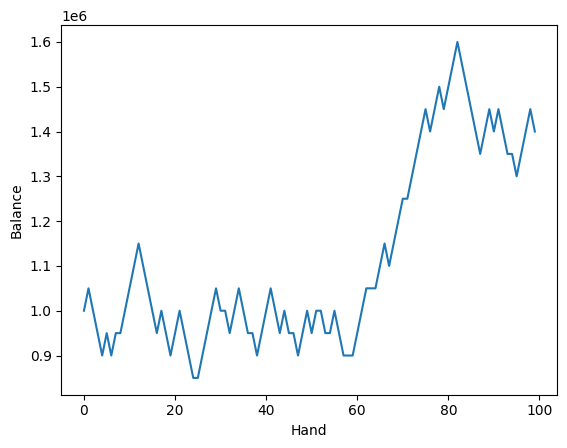

   Hand     Dealer_Cards Player_Cards Decision      Bet Result   Amount
0     1        [7, 3, 9]      [10, A]    Stand  50000.0    win  50000.0
1     2        [3, 7, K]    [7, 2, 9]      Hit  50000.0   lose -50000.0
2     3        [2, 6, 9]    [2, Q, A]      Hit  50000.0   lose -50000.0
3     4           [K, J]   [K, 3, 10]      Hit  50000.0   lose -50000.0
4     5           [J, 8]       [A, Q]    Stand  50000.0    win  50000.0
..  ...              ...          ...      ...      ...    ...      ...
95   96     [K, 2, 4, 6]       [J, 7]    Stand  50000.0    win  50000.0
96   97          [7, 10]       [K, J]    Stand  50000.0    win  50000.0
97   98     [2, 8, 5, 4]       [J, A]    Stand  50000.0    win  50000.0
98   99  [2, 3, 7, A, 8]       [9, J]    Stand  50000.0   lose -50000.0
99  100        [9, 6, 3]       [8, K]    Stand  50000.0   draw      0.0

[100 rows x 7 columns]
Final Balance: 1400000
Total Profit: 400000
Times Won: 47
Times Lost: 39
Times Draw: 14
Insurances Taken: 0
Long

In [40]:
if __name__ == "__main__":
    game = Game()
    initial_balance = game.player.balance
    for i in range(100):
        game.play_round(i)
        if game.player.balance < game.player.bet:  # Stop the game if the player's balance is less than the initial bet
            print("Game stopped, the player's balance is less than the initial bet.")
            break
    game.plot_balance()
    print(game.decisions)

    # Summary
    final_balance = game.player.balance
    profit_or_loss = final_balance - initial_balance
    print(f"Final Balance: {final_balance}")
    print(f"Total {'Profit' if profit_or_loss >= 0 else 'Loss'}: {abs(profit_or_loss)}")
    print(f"Times Won: {len(game.decisions[game.decisions['Result'] == 'win'])}")
    print(f"Times Lost: {len(game.decisions[game.decisions['Result'] == 'lose'])}")
    print(f"Times Draw: {len(game.decisions[game.decisions['Result'] == 'draw'])}")
    print(f"Insurances Taken: {game.insurances_taken}")
    print(f"Longest Win Streak: {max(sum(1 for _ in g) for k, g in itertools.groupby(game.decisions['Result']) if k=='win')}")
    print(f"Longest Loss Streak: {max(sum(1 for _ in g) for k, g in itertools.groupby(game.decisions['Result']) if k=='lose')}")